# tweetlist demo

tweetlist is a python package used to conveniently perform many consecutive search requests to the Twitter API (with cooldowns), aggregate the data, then use it to plot maps and train machine learning algorithms. We are going to look at several examples to see how it can be used in practice. We start by importing the module.

## Table of contents

1) <a href=#region>Mapping regionalisms</a>

2) <a href=#magaresist>Classifying #MAGA vs. #resist tweets</a>

In [2]:
import tweetlist1 as tl
import matplotlib.pyplot as plt
tl.py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


We will need tokens to access the Twitter API. Each individual user will need to get their own from https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens.html.

In [11]:
with open('tokens.txt', 'r') as f:
    API_KEY = f.readline().strip()
    API_SECRET = f.readline().strip()
    ACCESS_TOKEN = f.readline().strip()
    TOKEN_SECRET = f.readline().strip()
tokens = [API_KEY, API_SECRET, ACCESS_TOKEN, TOKEN_SECRET]

<a name='region'/>

## Mapping regionalisms

Let's search recent tweets to see how certain expressions are geographically distributed throughout the country. tweetlist infers the city and/or state of a tweet's author when possible from the location field of their profile. If a user hasn't provided a location or has entered a joke location like "Krypton," then the location is null and the tweet is ignored for mapping purposes.

Let's start by seeing where people tend to use "y'all" in their tweets. We first perform a search to gather some tweets. The following line of code will search for tweets containing "y'all," pausing for cooldowns when required by Twitter's rate limiting, and continuing for 5 hours total. These results will be aggregated in a pandas DataFrame which is then pickled to the given output file location. Since `process` is set to True, the function `process_df` is called after each batch of results is obtained, inferring the location and local time for each tweet when possible. This will be pickled to "processed_yall_tweets_6_1." Finally, the processed dataframe is returned.

In [ ]:
yall_df = tl.repeated_search_loops(tokens, "y'all", 5, output_file = 'yall_tweets_6_1', 
                                   process = True)

Now we can use the aggregated tweets to build a TweetList object. We can do this by passing either a dataframe or a corresponding pickle file, and the dataframe can be "processed" in the above sense or not. If it isn't then it will be processed at initialization. Similarly we can append further search results in any of these formats as well.

In [ ]:
yall_tl = tl.TweetList(yall_df)
yall_tl.append('yall_tweets_5_11')

Now we draw a `plotly` map showing the prevalence of such tweets by state. By default `draw_state_map` will color each state by (a constant multiple of) the number of tweets per capita for that state. This is referred to as "adjusted tweet rate" when labeling the color bar. The default color scale goes from white (low) to blue (high). All of this however is customizable.

In [19]:
yall_tl.draw_state_map(title = "Prevalence of y'all by state", notebook_mode = True)

Not surprisingly, Texas and other southern states have a higher prevalence of "y'all" than northern states. We can also look at this data in a table by calling the `.by_state()` method and sorting by the "rate" column.

In [20]:
yall_tl.by_state().sort_values('rate', ascending=False).head()

,index,state,abb,count,population,rate
7,7,d.c.,dc,6847,693972,0.009866
44,44,texas,tx,139829,28304596,0.004940
18,18,louisiana,la,22311,4684333,0.004763
10,10,georgia,ga,42160,10429379,0.004042
20,20,maryland,md,19361,6052177,0.003199


Let's look at a regionalism with a different geographical pattern, the adverbial "wicked," e.g. "wicked smart" (or "wicked smaaaht" as it were). We can acquire the data and use it to build a TweetList object just as before.

In [8]:
wicked_tl = tl.TweetList('wicked_tweets_5_2_processed')
wicked_tl.append('wicked_tweets_5_4_processed')
wicked_tl.append('wicked_tweets_5_7_processed')
wicked_tl.append('wicked_tweets_5_15_processed')
wicked_tl.append('wicked_tweets_5_23_processed')

We could use nltk POS tagging to find the part of speech of the word following "wicked" in a tweet but this can be inconsistent, not just due to errors from nltk but also because some people omit commas in lists of adjectives, e.g. tweeting about "this wicked horrible nasty person" where "wicked" is probably intended as an adjective. So instead we'll just specifically list a few common phrases that use "wicked" as an adverb and create a mask to select only tweets containing such a phrase.

In [9]:
def has_wicked_phrase(text):
    wicked_phrases = ['wicked smart', "wicked cool", "wicked awesome", "wicked fun", "wicked cold", 
                  "wicked hot", "wicked lame", "wicked stupid", "wicked hungry", "wicked thirsty"]
    for k in range(1,5):
        wicked_phrases.append("wicked sm{}ht".format("a" * k))
    for phrase in wicked_phrases:
        if phrase in text.lower():
            return True
    return False
rb_wicked_mask = wicked_tl.data.text.apply(has_wicked_phrase)

Now we can draw a map using this mask. We will also manually set a custom color scheme for this map.

In [29]:
wicked_tl.draw_state_map(mask = rb_wicked_mask, notebook_mode = True,
                         color_scale = [(0, 'rgb(235,235,235)'), (1, 'rgb(20,175,20)')],
                         title = "Prevalence of adverbial 'wicked' by state")

The bubble map illustrates how much of an outlier Boston is in the number of adverbial "wicked" tweets. Here we use the default settings for the `draw_bubble_map` method. The size of the bubbles represents the number of tweets, while the color is determined by tweets per capita. The color scheme and the quantity used for coloring can be set by the user.

In [10]:
wicked_tl.draw_bubble_map(mask = rb_wicked_mask, notebook_mode = True,
                          title = "Prevalence of adverbial 'wicked' by city")

In [36]:
wicked_by_city.head(10)

,index,city,state,population,lat,lon,count,rate
34,34,boston,massachusetts,645966.0,42.360082,-71.058880,233,0.000361
21,21,baytown,texas,75418.0,29.735505,-94.977427,20,0.000265
184,184,mishawaka,indiana,47989.0,41.661993,-86.158616,9,0.000188
232,232,portland,maine,66318.0,43.661471,-70.255326,12,0.000181
298,298,vancouver,washington,167405.0,45.638728,-122.661486,23,0.000137
255,255,salem,massachusetts,42544.0,42.519540,-70.896715,5,0.000118
88,88,east providence,rhode island,47149.0,41.813712,-71.370054,5,0.000106
43,43,cambridge,massachusetts,107289.0,42.373616,-71.109734,9,0.000084
223,223,pensacola,florida,52703.0,30.421309,-87.216915,4,0.000076
152,152,leominster,massachusetts,41002.0,42.525091,-71.759794,3,0.000073


<a name='magaresist'/>

## Classifying #MAGA vs. #resist tweets

Next we try to train a classifier to label tweets as either '#MAGA' or '#resist'. We initialize a TweetList object, but this time we pass values for the `masks_for_groups` and `cat_names` parameters. There are several ways the former can be passed (see the documentation for the `__init__` method). We then append another chunk of data which is automatically labeled in the prescribed way.

In [2]:
trump_tl = tl.TweetList('processed_trump_tweets_5_15', subject = 'Trump', 
                              masks_for_groups = [['user_description', '#MAGA'], 
                                                  ['user_description', '#resist|#theresist']],
                              cat_names = ['#MAGA', '#resist'])
trump_tl.append('trump_tweets_5_11')

Before training a classifier, let's see what hours tend to have the most tweets about Trump, and let's also view a bubble map showing where these tweets are coming from and the balance of the two labels from each location.

<Container object of 24 artists>

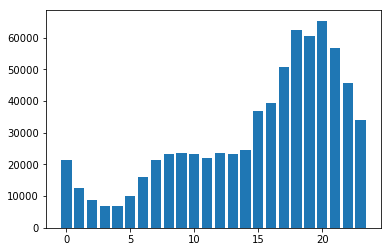

In [5]:
hour_counts = trump_tl.data.groupby('hour')['text'].count()
plt.bar(left=hour_counts.index.values, height=hour_counts)

In [3]:
trump_tl.draw_label_ratio_bubble_map('#MAGA', notebook_mode = True)

Now we can train the two default classifiers on our data. For neural network training, the user can pass their own keras model to use instead of the default bi-directional GRU model, or can alter the number of units in the dense layer and/or any of the three dropout values. The number of epochs and the early stopping parameter can also be set manually if desired.

In [4]:
trump_tl.train_nb()

/Users/ryan/miniconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [ ]:
trump_tl.train_nn()

After training, a grid search is performed on weights for each label to ensure that the accuracy on each one is roughly the same as the others. (This prevents obtaining deceptively high accuracy on an imbalanced data set by always guessing the more common label.) We can use `get_accuracy` to see the accuracy on each label, and (in the case of binary classification) `plot_roc` to view the ROC.

In [5]:
trump_tl.get_accuracy(model = 'nb')

overall accuracy: 0.8204659661946094
#MAGA accuracy: 0.8227675528289026
#resist accuracy: 0.8157894736842105


[('overall', 0.8204659661946094),
 ('#MAGA', 0.8227675528289026),
 ('#resist', 0.8157894736842105)]

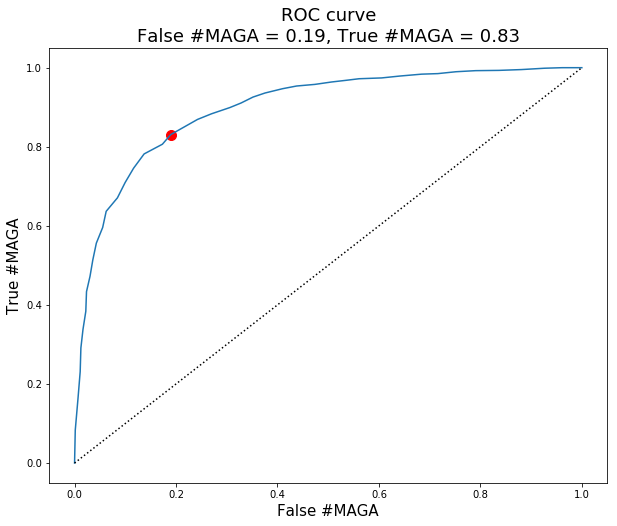

(0.830947511929107, 0.8102493074792244)

In [6]:
trump_tl.plot_roc(model = 'nb')